<center>Universidade Federal de Viçosa</center>
<center>Inteligência Artificial e Computacional</center>
<center>ELT578 - Análise de Imagens e Visão Computacional</center>
<center>TURMA 2022/2</center>

**<center>AULA PRÁTICA 5: Análise de imagens via Redes Neurais Convolucionais</center>**
<center>Aluno: Michel Batistin Fiorio</center>

Em visão computacional, após aplicadas as técnicas necessárias de processamento das imagens, chegamos na tarefa de análise da imagem processada. Nesse passo serão utilizadas técnicas de inteligência artificial para a retirada das informações desejadas da imagem e a subsequente aplicação prática da interpretação realizada na imagem. Exemplos de aplicações práticas são a classificação de imagens em determinados grupos e técnicas de regressão. Nessa atividade realizaremos o carregamento de um banco de dados de imagens de diferentes tipos de flores, processaremos as imagens e treinaremos uma rede neural convolucional para classificar o tipo de flor.

This tutorial shows how to load and preprocess an image dataset in three ways:

- First, you will use high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk.
- Next, you will write your own input pipeline from scratch [using tf.data](../../guide/data.ipynb).
- Finally, you will download a dataset from the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) available in [TensorFlow Datasets](https://www.tensorflow.org/datasets).

In [1]:
# Importanto bibliotecas

import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt

## Carregando o banco de dados das flores utilizando função de alto nivel `tf.keras.utils.image_dataset_from_directory`

O banco de dados possui milhares de imagens de flores dividido em 5 categorias diferentes:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
# Indicando o endereço do banco de dados
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# Fazendo download e extraindo os dados zipados para o cache
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
# Definindo caminho dos dados no diretório
data_dir = pathlib.Path(archive).with_suffix('')

In [3]:
# Obtendo a lista das subpastas dentro da pasta raiz do arquivo baixado
subdirectories = [name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))]

# Mostrando os nomes das subpastas
for subdirectory in subdirectories:
    print(subdirectory)

tulips
sunflowers
dandelion
daisy
roses


In [4]:
# Iteração para contar os números de fotos dentro de cada subpasta
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(data_dir, subdirectory)
    num_items = len(os.listdir(subdirectory_path))
    print(f"Pasta: {subdirectory} | Número de itens: {num_items}")

Pasta: tulips | Número de itens: 799
Pasta: sunflowers | Número de itens: 699
Pasta: dandelion | Número de itens: 898
Pasta: daisy | Número de itens: 633
Pasta: roses | Número de itens: 641


In [5]:
# Mostrando o endereço do banco de dados e contagem do número de arquivos de imagem total
image_count = len(list(data_dir.glob('*/*.jpg')))
print('Endereço do banco de dados:', data_dir)
print('Número total de imagens:', image_count)

Endereço do banco de dados: /root/.keras/datasets/flower_photos
Número total de imagens: 3670


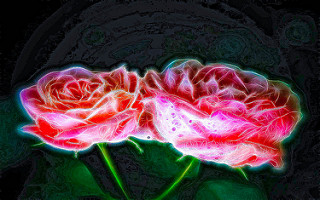

In [6]:
# Carregando a lista de imagens contida na subpasta 'roses'
roses = list(data_dir.glob('roses/*'))
# Mostrando uma imagem
PIL.Image.open(str(roses[344]))

### Utilizando ferramentas do Keras para preparar o banco de dados das imagens para treinamento da CNN


Um banco de dados para treinamento de uma rede neural convolucional precisa ter todas as fotos com tamanho padronizado. No nosso caso padronizaremos no tamanho 180x180 pixels.

Definiremos também o tamanho do lote de fotos que será apresentado à rede neural em cada iteração de treinamento. Isso significa que não são todas as fotos que são apresentadas de uma vez e sim pacotes de fotos. No nosso caso definiremos um tamanho de lote (batch_size) de 32 fotos.

Dentro do banco de dados de treinamento se faz necessário a separação de uma parte das fotos para treinamento em si e outra parte para validação do treinamento da rede. Isso permite que tenhamos um grupo de imagens separadas exclusivamente para validar a eficiência do aprendizado da rede com as outras fotos do banco. No nosso caso utilizaremos um fator 80x20, 80% das fotos para treinamento e 20% para validação.

Por último, se faz necessário a normalização dos dados das imagens. Os pixels contém informação de cor na faixa de 0-255. O ideal para uma rede neural é apresentarmos imagens com dados em uma faixa pequena padronizada, normalmente 0-1. Isso evita que a rede dê pesos diferentes para detalhes diferentes das imagens, levando a um treinamento de baixa acurácia.

In [7]:
# Definindo parâmetros de tamanho do lote e tamanho das imagens
batch_size = 32
img_height = 180
img_width = 180

In [8]:
# Carregando a parcela das fotos a serem utilizados no treinamento (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
# Carregando a parcela das fotos a serem utilizados na validação (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
# Obtendo a informação dos nomes das classes de flores constante do banco de dados
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


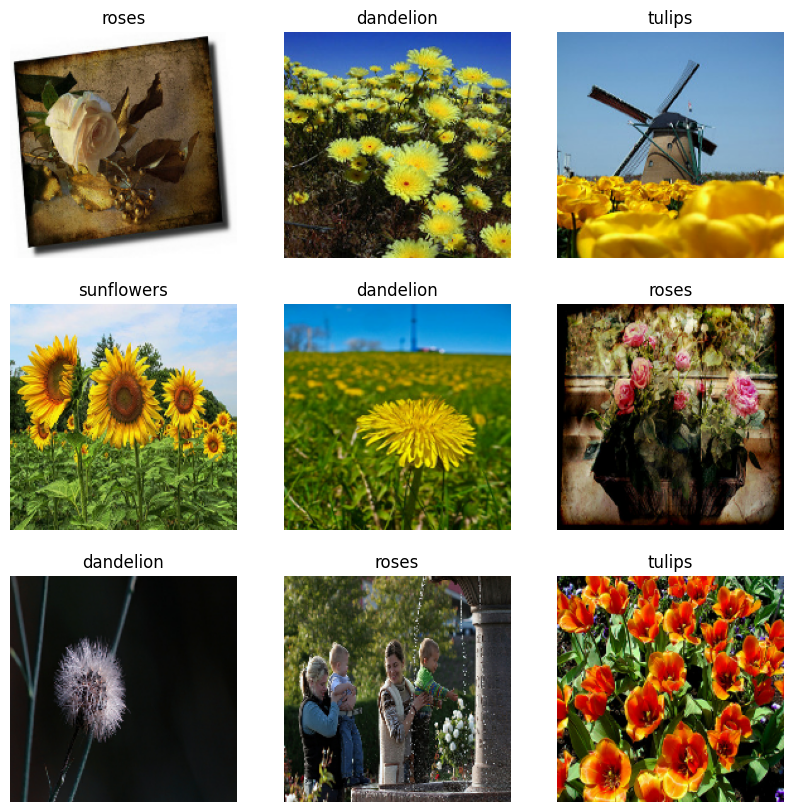

In [11]:
# Carregando nove imagens do banco de dados de treinamento
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
# Realizando a normalização das imagens

# Esse processo pode ser feito de duas formas diferentes.
# Pode ser feito a normalização prévia dos dados, usando a função 'Dataset.map'.
# Ou pode-se utilizar uma linha de comando dentro da criação do modelo da CNN
# O comando é o 'tf.keras.layers.Rescaling(1./255)
# Usaremos na nossa atividade a segunda opção.

normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
# Apenas para fins de exemplo, realizando a normalização dos dados com 'Dataset.map'
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Observe que os pixels agora estão entre 0 e 1
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Configurando os dados para performance do treinamento



Como os dados estão em Cache na internet, para garantir que durante o treinamento da rede não ocorrerão bloqueios de leitura dos dados, serão utilizados duas funções para realização do buffer dos dados do banco de dados. Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache`: mantem a imagem na memória após ela ser carregada na primeira época de treinamento da CNN. Garantirá que o dado estará disponível durante o treinamento. Caso o volume de dados sejá muito grande para a memória, o método pode ser utilizado para criar um cache em disco de alto desempenho.
- `Dataset.prefetch`: permtie que um arquivo seja transferido antes que a ação seja iniciada.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Treinando o modelo da CNN

Arquitetura da rede CNN a ser treinada com o banco de dados carregado anteriormente:
  - Camada para normalização dos dados das imagens (Rescaling);
  - Camada convolucional com 32 filtros e função ativação relu;
  - Camada maxpooling;
  - Camada convolucional com 32 filtros e função ativação relu;
  - Camada maxpooling;
  - Camada convolucional com 32 filtros e função ativação relu;
  - Camada maxpooling;
  - Camada para transformar as matrizes das imagens em um array linear
  - Camada de neurônios totalmente conectados composto de 128 neurônios e função de ativação relu
  - Camada de saída com 5 neurônios para classificação das 5 classes diferentes de flores.

In [15]:
# Criando o modelo da rede
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [16]:
# Compilando o modelo utilizando ootimizador 'adam' e a função de perda 'Cross Entropy'

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
# Treinando o modelo com o banco de dados das flores
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 [==============================] - 19s 90ms/step - loss: 1.2807 - accuracy: 0.4700 - val_loss: 1.1350 - val_accuracy: 0.5490
Epoch 2/10
92/92 [==============================] - 2s 26ms/step - loss: 1.0052 - accuracy: 0.6025 - val_loss: 1.0024 - val_accuracy: 0.5872
Epoch 3/10
92/92 [==============================] - 2s 25ms/step - loss: 0.8527 - accuracy: 0.6696 - val_loss: 0.9170 - val_accuracy: 0.6444
Epoch 4/10
92/92 [==============================] - 2s 25ms/step - loss: 0.6841 - accuracy: 0.7391 - val_loss: 0.9380 - val_accuracy: 0.6635
Epoch 5/10
92/92 [==============================] - 2s 27ms/step - loss: 0.5254 - accuracy: 0.8048 - val_loss: 0.9671 - val_accuracy: 0.6798
Epoch 6/10
92/92 [==============================] - 2s 26ms/step - loss: 0.4214 - accuracy: 0.8440 - val_loss: 1.0798 - val_accuracy: 0.6526
Epoch 7/10
92/92 [==============================] - 2s 25ms/step - loss: 0.3512 - accuracy: 0.8706 - val_loss: 1.1346 - val_accuracy: 0.6458
Epoch 8/10
9

Foram utilizadas apenas 10 épocas no treinamento para minimizar o tempo de processamento. Entretando, já podemos observar a ocorrência de sobreajuste dos parâmetros da rede aos dados de treinamento. A partir da quarta época a acurácia de treinamento segue aumentando enquanto a acurácia de validação apresenta queda. Existem diversas técnicas para evitar sobreajuste durante treinamento de redes neurais, mas elas não serão trabalhadas nessa atividade.

## Usando função 'tf.data' para controles personalizados do banco de dados

No inicio da atividade usamos a função `tf.keras.utils.image_dataset_from_directory` para criação conveniente de um banco de dados (Dataset) de flores a partir de um diretório de imagens.

Podemos também utilizar da função `tf.data` do Tensorflow para escrever nosso próprio pipeline, ganhando flexibilidade e um controle mais fino dos dados do dataset. Criaremos, portanto, o dataset de treinamento a partir do caminho do arquivo de flores que fizemos o download anteriormente.

In [18]:
# Listando os arquivos do diretório 'data_dir'
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [19]:
# Mostrando o nome do quinto arquivo dentro de cada pasta do diretório
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/dandelion/136999986_e410a68efb_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/3419176626_512811d3ff.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/6983105424_f33cc9b08d_m.jpg'
b'/root/.keras/datasets/flower_photos/daisy/2666572212_2caca8de9f_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/13231224664_4af5293a37.jpg'


In [20]:
# Obtendo o nome das pastas dentro do diretório
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [21]:
# Dividindo o banco de dados entre dados de treinamento (80%) e validação(20%)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [22]:
# Imprimindo o tamanho de cada grupo de dados após a divisão
print('Tamanho banco dados de treinamento:', tf.data.experimental.cardinality(train_ds).numpy())
print('Tamanho banco de dados de validação:',tf.data.experimental.cardinality(val_ds).numpy())

Tamanho banco dados de treinamento: 2936
Tamanho banco de dados de validação: 734


Vamos agora definir algumas funções para converter o endereço de uma imagem do banco de dados em um par imagem/classe de flor: `(img, label)`

In [23]:
def get_label(file_path):
  # Converter o caminho em uma lista de componentes do caminho
  parts = tf.strings.split(file_path, os.path.sep)
  # O penúltimo é o diretório de classe
  one_hot = parts[-2] == class_names
  # Codificar o nome em um inteiro
  return tf.argmax(one_hot)

In [24]:
def decode_img(img):
  # Converta a string compactada em um tensor uint8 3D
  img = tf.io.decode_jpeg(img, channels=3)
  # Redimensione a imagem para o tamanho desejado
  return tf.image.resize(img, [img_height, img_width])

In [25]:
def process_path(file_path):
  label = get_label(file_path)
  # Carregue os dados brutos do arquivo como uma string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [26]:
# Usando 'Dataset.map' para criar banco de dados de pares 'image,label' para treinamento e validação
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [27]:
# Obtendo o tamnho e classe de uma imagem do banco de dados de treinamento
for image, label in train_ds.take(1):
  print("Tamanho da imagem: ", image.numpy().shape)
  print("Classe da flor: ", label.numpy())

Tamanho da imagem:  (180, 180, 3)
Classe da flor:  3


### Configurando os dados para performance do treinamento

In [28]:
# Vamos definiar uma função que irá configurar o banco de dados para melhor performance.
# Dessa forma os banco de dados terão dados corretamente embaralhados, empacotados e disponíveis para um rápido carregamento

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# Aplicando a função nos bancos de dados de treinamento e validação
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

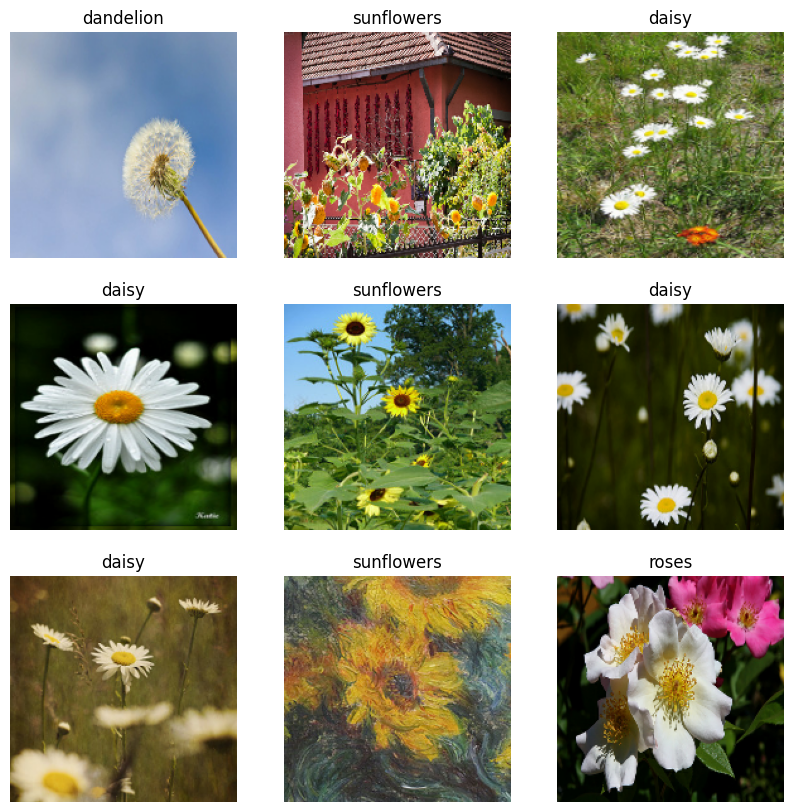

In [29]:
# Mostrando as nova primeiras imagens do banco de dados de treinamento
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Treinando o modelo da CNN

In [30]:
# Vamos agora treinar o modelo de rede criado anteriormente mas usando agora
# os bancos de dados que acabamos de montar manualmente através das funções 'tf.data'
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 [==============================] - 19s 180ms/step - loss: 0.3237 - accuracy: 0.9091 - val_loss: 0.4245 - val_accuracy: 0.8787
Epoch 2/10
92/92 [==============================] - 3s 30ms/step - loss: 0.1214 - accuracy: 0.9663 - val_loss: 0.3756 - val_accuracy: 0.9060
Epoch 3/10
92/92 [==============================] - 3s 29ms/step - loss: 0.0402 - accuracy: 0.9915 - val_loss: 0.4682 - val_accuracy: 0.8924
Epoch 4/10
92/92 [==============================] - 3s 31ms/step - loss: 0.0182 - accuracy: 0.9956 - val_loss: 0.5070 - val_accuracy: 0.9019
Epoch 5/10
92/92 [==============================] - 3s 29ms/step - loss: 0.0066 - accuracy: 0.9997 - val_loss: 0.5550 - val_accuracy: 0.8992
Epoch 6/10
92/92 [==============================] - 3s 32ms/step - loss: 0.0038 - accuracy: 0.9997 - val_loss: 0.5613 - val_accuracy: 0.9019
Epoch 7/10
92/92 [==============================] - 4s 41ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.5815 - val_accuracy: 0.9033
Epoch 8/10


## Usando banco de dados do TensorFlow

Até o momento carregamos e configuramos os bancos de dados através de dados carregados de um diretório em um endereço URL. Fizemos isso inicialmente utilziando uma função de alto nível do Keras e depois fizemos manualmente com as funções do Tensorflow.
A paltaforma do Tensorflow disponibiliza diversos datasets que podem ser baixados e usados de maneira fácil. Eles ficam listados no endereço (https://www.tensorflow.org/datasets/catalog/overview).

Vamos então agora mostrar como importar um desses banco de dados disponíveis.

In [31]:
# Carregando o banco de dados 'tf_flowers' direto do Tensorflow
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [32]:
# Obtendo o número de classes diferentes do banco de dados
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


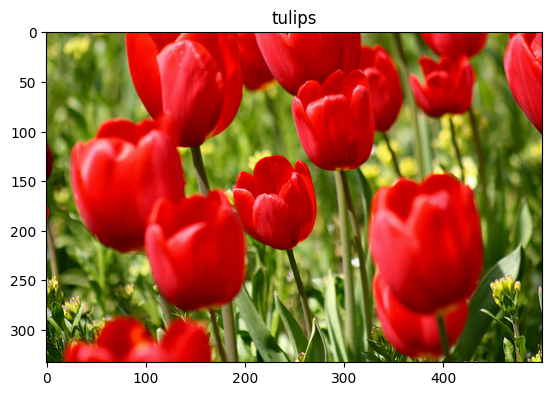

In [33]:
# Mostrando uma imagem do banco de dados
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))